# Preamble

## Imports

Standard imports

In [1]:
import sys, os, re, time, copy
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import unidecode

Language libraries:

In [2]:
from textblob import TextBlob

### Settings

Disable copy warnings in Pandas

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

Disable depreciation warnings

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

-----
# Step 1: Inspect the data
-----

## Load the data

In [5]:
review_df = pd.read_excel('facebook_review_dataset.xlsx')

## Inspect the data

### Dataset

In [6]:
print(f"The dataset contains {len(review_df)} reviews. \nThe oldest review is from {review_df['date'].min()} \nThe newest review is from {review_df['date'].max()}.")
review_df.head(2)

The dataset contains 2290 reviews. 
The oldest review is from 2014-03-17 00:00:00 
The newest review is from 2021-12-28 00:00:00.


,date,year,rating,rating_wlb,rating_culture,rating_dei,rating_comp,job_title,location,pros,cons
0,2021-11-09,2021,5,5,5,5,5,Software Engineer,"Seattle, WA","I’m still a bit new, but I have very good impr...",Some risk with new company direction. The meta...
1,2021-12-25,2021,5,5,5,4,4,Data Scientist,"San Francisco, CA","Its all you hear about, fun and diverse and su...",You are evaluated nased on individual accompli...


### Number of reviews by year

In [7]:
review_df.value_counts('year').sort_index(ascending=False)

year
2021    1123
2020     572
2019     226
2018     239
2017     128
2016       1
2014       1
dtype: int64

### Show random review

**Note:** Every time you run the code below it will show a different review in the dataset.

In [8]:
review_row = review_df.sample(1).iloc[0].to_dict()
print(f"Review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros: \n\n{review_row['pros'].strip()}")
print(f"\nCons: \n\n{review_row['cons'].strip()}")

Review by a Software Engineering in Menlo Park, CA on 2017-06-22 00:00:00

Pros: 

Nice and passionate people. Lots of work for engineers. Many opportunities. Many supports for employees. Many of employees are smart.

Cons: 

Normally busy. Inexperienced engineers sometimes lead the project, which causes a mess. People move too fast and break things, which is not good for engineering perspective.


## 

-----
# Step 2: Clean the data
-----

### Cleaning function

In [9]:
def clean_text(input_str):
    clean_str = copy.copy(input_str)

    ## Remove special characters
    clean_str = unidecode.unidecode(clean_str)

    ## Remove any non-letter characters except for regular sentence-ending punctuation
    clean_str = re.sub(r'[^a-zA-Z\s\.!\?\\n]', '', clean_str)

    ## Replace all \s with a single space except for \n
    clean_str = re.sub(r'[ \t\x0B\f\r]+', ' ', clean_str)

    ## Replace a newline with a dot and a space
    clean_str = re.sub(r'\s*\n\s*', '. ', clean_str)

    ## Replace duplicate dots
    clean_str = re.sub(r'\.+', '.', clean_str)

    ## Remove any leading or trailing spaces
    clean_str = clean_str.strip()

    ## Add trailing dot if not exists
    if clean_str[-1] != '.':
        clean_str += '.'

    return clean_str

### Run

In [10]:
review_df['pros_clean'] = review_df['pros'].apply(clean_text)
review_df['cons_clean'] = review_df['cons'].apply(clean_text)

#### Add lower case version

In [11]:
review_df['pros_clean_l'] = review_df['pros_clean'].str.lower()
review_df['cons_clean_l'] = review_df['cons_clean'].str.lower()

### Inspect

In [12]:
review_row = review_df.sample(1).iloc[0].to_dict()
print(f"Review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros: \n\n{review_row['pros'].strip()}")
print(f"\nPros clean: \n\n{review_row['pros_clean'].strip()}")
print('\n' + '-'*50)
print(f"\nCons: \n\n{review_row['cons'].strip()}")
print(f"\nCons clean: \n\n{review_row['cons_clean'].strip()}")

Review by a Product Design in Menlo Park, CA on 2019-05-04 00:00:00

Pros: 

Great design community. Solid internal tools that make your job easier.

Pros clean: 

Great design community. Solid internal tools that make your job easier.

--------------------------------------------------

Cons: 

Big company can be challenging getting lots of teams to align on an idea.

Cons clean: 

Big company can be challenging getting lots of teams to align on an idea.


-----
# Step 3: Analyze the data
-----

## Key word analysis 

### Check whether each pros and cons contains a keyword

In [13]:
keywords_of_interest = ['traffic', 'culture', 'salary', 'diversity', 'balance']
text_types = ['pros', 'cons']
contains_columns = []
for text_type in text_types:
    for keyword in keywords_of_interest:
        review_df[f'{text_type}_contains_{keyword}'] = review_df[f'{text_type}_clean_l'].str.contains(keyword)**1
        contains_columns.append(f'{text_type}_contains_{keyword}')

In [14]:
review_df.sample(2).T

,1122,1010
date,2020-12-23 00:00:00,2021-01-31 00:00:00
year,2020,2021
rating,5,3
rating_wlb,5,1
rating_culture,3,1
rating_dei,5,1
rating_comp,4,1
job_title,Software Engineer,Mobile Engineer
location,"Menlo Park, CA","San Francisco, CA"
pros,i love working here so much,good perks and also free food so it's very nice


### Create aggregate dataframe

In [15]:
review_kw_df = review_df[contains_columns].sum().reset_index().rename(columns={'index' : 'group', 0 : 'count'})
tmp_df = review_kw_df['group'].str.split('_', expand=True).rename(columns={0 : 'text_type', 2 : 'keyword'}).drop(1,axis=1)
review_kw_df = pd.concat([review_kw_df, tmp_df], axis=1)
review_kw_df = review_kw_df[['keyword', 'text_type', 'count']].sort_values(by='keyword', ascending=False)

In [16]:
review_kw_df

,keyword,text_type,count
0,traffic,pros,0
5,traffic,cons,9
2,salary,pros,125
7,salary,cons,12
3,diversity,pros,34
8,diversity,cons,28
1,culture,pros,407
6,culture,cons,155
4,balance,pros,118
9,balance,cons,279


## Sentiment analysis

### Add the sentiment to the dataframe

In [17]:
def add_sentiment(input_str):
    return TextBlob(input_str).sentiment.polarity

In [18]:
review_df['pros_sentiment'] = review_df['pros_clean'].apply(add_sentiment)
review_df['cons_sentiment'] = review_df['cons_clean'].apply(add_sentiment)
review_df['average_sentiment'] = (review_df['pros_sentiment'] + review_df['cons_sentiment'])/2

### Inspect scores, are they reasonable?

In [19]:
review_row = review_df.sample(1).iloc[0].to_dict()
print(f"Review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros clean (sentiment: {review_row['pros_sentiment']:.2f}): \n\n{review_row['pros_clean'].strip()}")
print('\n' + '-'*50)
print(f"\nCons clean (sentiment: {review_row['cons_sentiment']:.2f}): \n\n{review_row['cons_clean'].strip()}")

Review by a SWE Intern in Menlo Park, CA on 2021-03-04 00:00:00

Pros clean (sentiment: 0.04): 

High salary and fast past.

--------------------------------------------------

Cons clean (sentiment: 0.00): 

Low works life balance and.


### Show summary statistics for the sentiment

In [20]:
review_df[['pros_sentiment', 'cons_sentiment']].describe()

,pros_sentiment,cons_sentiment
count,2290.000000,2290.000000
mean,0.429227,0.046158
std,0.280898,0.279836
min,-1.000000,-1.000000
25%,0.228921,-0.050000
50%,0.450000,0.000000
75%,0.650000,0.200000
max,1.000000,1.000000


### Show examples of high and low sentiment reviews

In [21]:
top_pos_df = review_df.sort_values(by=['pros_sentiment', 'cons_sentiment'], ascending=False).head(20)
top_neg_df = review_df.sort_values(by=['pros_sentiment', 'cons_sentiment'], ascending=True).head(20)

In [22]:
review_row = top_pos_df.sample(1).iloc[0].to_dict()
print(f"Very positive review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros clean (sentiment: {review_row['pros_sentiment']:.2f}): \n\n{review_row['pros_clean'].strip()}")
print('\n' + '-'*50)
print(f"\nCons clean (sentiment: {review_row['cons_sentiment']:.2f}): \n\n{review_row['cons_clean'].strip()}")

Very positive review by a Software Engineer in New York, NY on 2021-03-24 00:00:00

Pros clean (sentiment: 1.00): 

best company in the world.

--------------------------------------------------

Cons clean (sentiment: 0.50): 

Thank you for doing your part to keep Glassdoor the most trusted.


In [23]:
review_row = top_neg_df.sample(1).iloc[0].to_dict()
print(f"Very negative review by a {review_row['job_title']} in {review_row['location']} on {review_row['date']}")
print(f"\nPros clean (sentiment: {review_row['pros_sentiment']:.2f}): \n\n{review_row['pros_clean'].strip()}")
print('\n' + '-'*50)
print(f"\nCons clean (sentiment: {review_row['cons_sentiment']:.2f}): \n\n{review_row['cons_clean'].strip()}")

Very negative review by a Technical Sourcer in Austin, TX on 2021-12-02 00:00:00

Pros clean (sentiment: -0.12): 

Facebooks perks are unmatched especially if youre coming from a small company.

--------------------------------------------------

Cons clean (sentiment: -0.15): 

hard to get promoted with how massive the company is.


### Did the sentiment change over time?

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
## Retina
sns.set(style="whitegrid", font_scale=1.2)

In [25]:
graph_df = review_df[review_df.year >= 2017]

#### Pros

Text(0, 0.5, 'Sentiment')

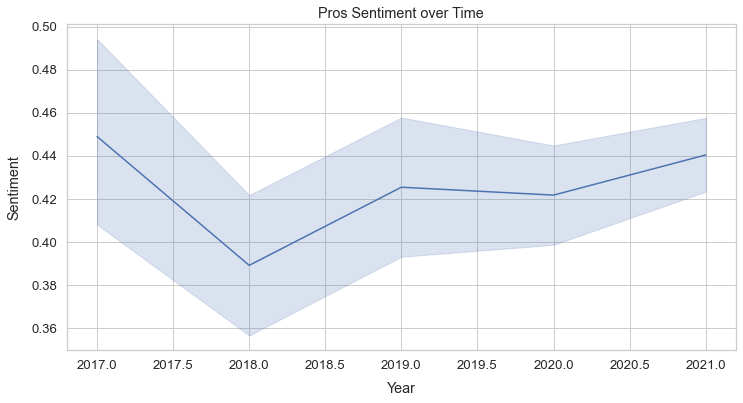

In [26]:
plt.figure(figsize=(12,6))
sns.lineplot(y='pros_sentiment', x='year', data=graph_df)

## make pretty
plt.title('Pros Sentiment over Time')
plt.xlabel('Year', labelpad=10)
plt.ylabel('Sentiment', labelpad=10)

#### Cons

Text(0, 0.5, 'Sentiment')

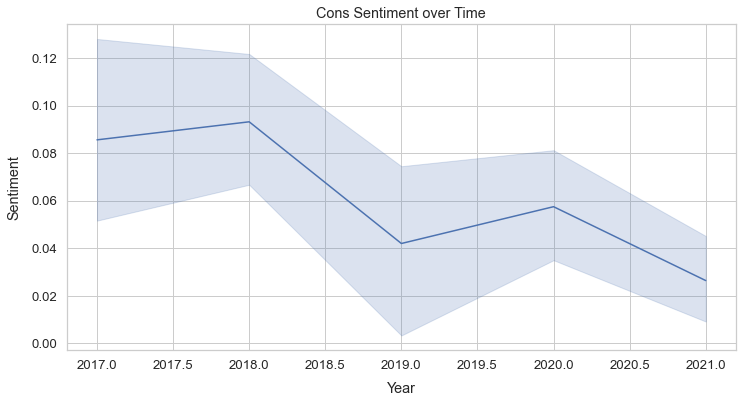

In [27]:
plt.figure(figsize=(12,6))
sns.lineplot(y='cons_sentiment', x='year', data=graph_df)

## make pretty
plt.title('Cons Sentiment over Time')
plt.xlabel('Year', labelpad=10)
plt.ylabel('Sentiment', labelpad=10)

### Does the average yearly sentiment and the average yearly ratings change similarly over time?

#### Text sentiment

Text(0, 0.5, 'Sentiment')

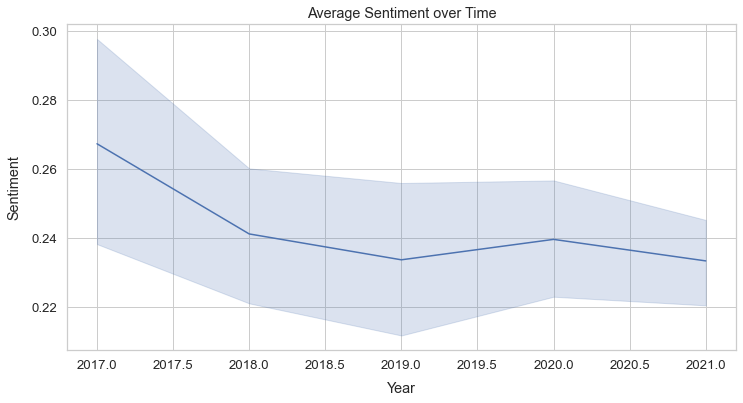

In [28]:
plt.figure(figsize=(12,6))
sns.lineplot(y='average_sentiment', x='year', data=graph_df)

## make pretty
plt.title('Average Sentiment over Time')
plt.xlabel('Year', labelpad=10)
plt.ylabel('Sentiment', labelpad=10)

### Rating sentiment

Text(0, 0.5, 'Rating')

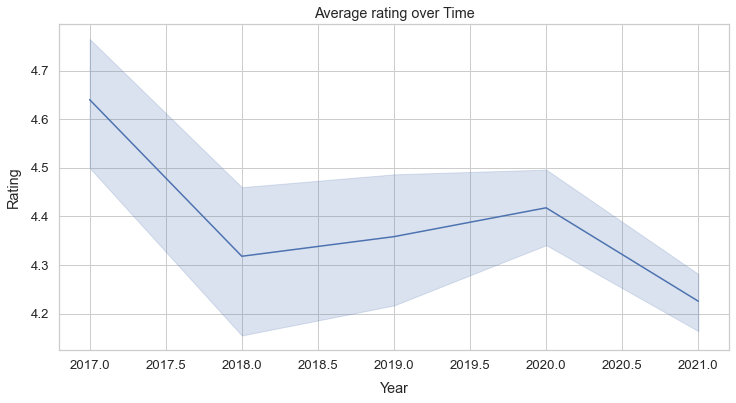

In [29]:
plt.figure(figsize=(12,6))
sns.lineplot(y='rating', x='year', data=graph_df)

## make pretty
plt.title('Average rating over Time')
plt.xlabel('Year', labelpad=10)
plt.ylabel('Rating', labelpad=10)

--------
# Advanced - LDA model
-------

## Prep the data

In [30]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
clean_pros_l = review_df['pros_clean_l'].tolist()
clean_cons_l = review_df['cons_clean_l'].tolist()

In [32]:
vec_pros = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
tf_pros = vec_pros.fit_transform(clean_pros_l)

vec_cons = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
tf_cons = vec_cons.fit_transform(clean_cons_l)

## Train the models

#### Pros

In [33]:
n_topics = 6
lda_pros = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                n_jobs=1)
lda_f_pros = lda_pros.fit_transform(tf_pros)

#### Cons

In [34]:
n_topics = 6
lda_cons = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                                learning_method='online',
                                n_jobs=1)
lda_f_cons = lda_cons.fit_transform(tf_cons)

## Visualize

In [35]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

### Pros

In [36]:
pyLDAvis.sklearn.prepare(lda_pros, tf_pros, vec_pros, n_jobs=1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.152401  0.011869       1        1  40.057093
1      0.265398  0.007002       2        1  21.192203
5     -0.085490 -0.322494       3        1  11.647228
3     -0.210456  0.079464       4        1   9.945463
2      0.049884  0.108215       5        1   8.641926
4     -0.171736  0.115944       6        1   8.516089, topic_info=          Term        Freq       Total Category  logprob  loglift
1718        xd  602.000000  602.000000  Default  30.0000  30.0000
658       good  577.000000  577.000000  Default  29.0000  29.0000
1694      work  775.000000  775.000000  Default  28.0000  28.0000
667      great  800.000000  800.000000  Default  27.0000  27.0000
118   benefits  540.000000  540.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1048      open   17.572955  116.941397   Topic6  -4.7714   0.5679
177     campus   12.667163   34.494953   Topic6  -5.0987   1.4614
1521      tech   12.561963   47.715886   Topic6  -5.1071   1.1286
1700   working   15.172235  159.501489   Topic6  -4.9183   0.1106
1248    really   12.266643  139.038481   Topic6  -5.1308   0.0353

[344 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2         6  0.960828  absolutely
44        1  0.965546     amazing
44        2  0.005191     amazing
44        3  0.015573     amazing
44        6  0.010382     amazing
...     ...       ...         ...
1725      1  0.980662       youll
1727      1  0.516978       youre
1727      4  0.433594       youre
1727      6  0.033353       youre
1728      6  0.872597       youve

[470 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 4, 3, 5])

### Cons

In [37]:
pyLDAvis.sklearn.prepare(lda_cons, tf_cons, vec_cons, n_jobs=1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.099917  0.057619       1        1  23.395763
1     -0.062309  0.180834       2        1  21.019421
2     -0.107534 -0.263296       3        1  16.212430
4      0.073164 -0.007518       4        1  15.961238
0     -0.109703  0.049639       5        1  13.714896
5      0.306299 -0.017280       6        1   9.696252, topic_info=          Term        Freq       Total Category  logprob  loglift
126    balance  243.000000  243.000000  Default  30.0000  30.0000
2072      work  555.000000  555.000000  Default  29.0000  29.0000
1032      life  180.000000  180.000000  Default  28.0000  28.0000
2093        xd  413.000000  413.000000  Default  27.0000  27.0000
324       cons   97.000000   97.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
947   internal   19.447423   52.342201   Topic6  -4.6780   1.3433
208     career   16.520758   42.542309   Topic6  -4.8411   1.3875
2072      work   28.244894  555.141737   Topic6  -4.3048  -0.6449
1095  managers   15.752564   80.425023   Topic6  -4.8887   0.7031
387    culture   12.636871  151.680652   Topic6  -5.1091  -0.1517

[357 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
25        4  0.893287    actual
26        1  0.956685  actually
67        6  0.950169       amp
93        4  0.915217     areas
119       6  0.878521     awful
...     ...       ...       ...
2098      4  0.191390     years
2104      1  0.697370     youre
2104      3  0.056240     youre
2104      4  0.056240     youre
2104      5  0.191214     youre

[485 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1, 6])